<h1 style="text-align: center">
Deep Learning HW4 </br>
RNN and LSTM
</h1>


### Full Name: Borna khodabandeh
### Student ID: 400109898

# Molecular Property Prediction with RNNs

This task involves solving binary classification problems for molecular properties using Sequential models. The BBBP dataset, containing 2053 molecular samples, is provided for predicting blood-brain barrier penetration. SMILES-encoded formulas and binary class labels `np_p` are available. We'll build RNN models to create molecular representations for classification. 

## Environment Setup

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Loading the dataset

here we will load the BBBP dataset, and create two new columns of `length`, which is the length of the smiles pattern, and `bin` which is the bin of 10 bins the molecule is in based on its length.

In [13]:
path = '../BBBP.csv'
# Kaggle
path = '/kaggle/input/bbbp-smiles/BBBP.csv'

df = pd.read_csv(path)
df['length'] = df['smiles'].apply(len)
bin_size = 10
df['bin'] = pd.qcut(df['length'], q=10, labels=False, duplicates='drop')
bin_indices = {bin_name: bin_data.index.tolist() for bin_name, bin_data in df.groupby('bin')}
df.head()

,num,name,p_np,smiles,length,bin
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,32,2
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,40,3
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,50,5
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,32,2
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,66,7


## Length visualization

here we will plot the `histplot` of the length of each smiles pattern, while dividing them by the `p_np` metric.

we can see from the plots that most of the smiles patterns have less than `120` characters, further down we will use this to truncate the length for the recurrent networks.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='length', ylabel='Count'>

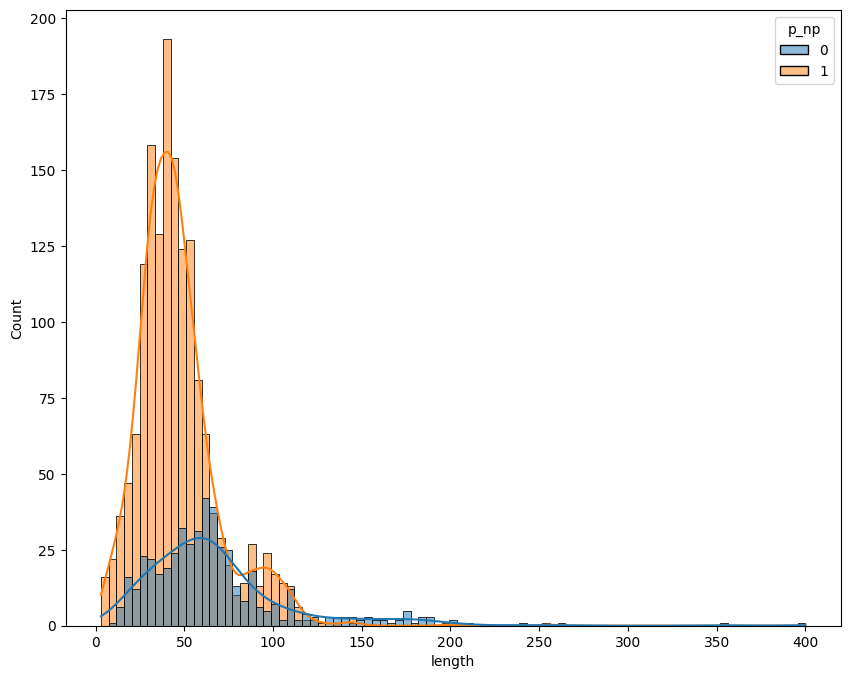

In [14]:
plt.figure(figsize = (10,8))
sns.histplot(data = df, x = 'length', hue = 'p_np', kde = True)

## Analyzing SMILES Tokens

This code analyzes the SMILES strings from the DataFrame (`df`) to understand the distribution of molecular tokens. SMILES strings encode molecular structures using ASCII characters.

1. **Token Extraction:**
   - The SMILES strings are tokenized using a regular expression pattern (`SMILE_REGEX_PATTERN`) from the DeepChem package.

2. **Visualization:**
   - The top 40 most frequent tokens are plotted to visualize their distribution.

3. **Vocabulary Information:**
   - The unique tokens and their count are printed.
   - The vocabulary size (number of unique tokens) is also displayed.

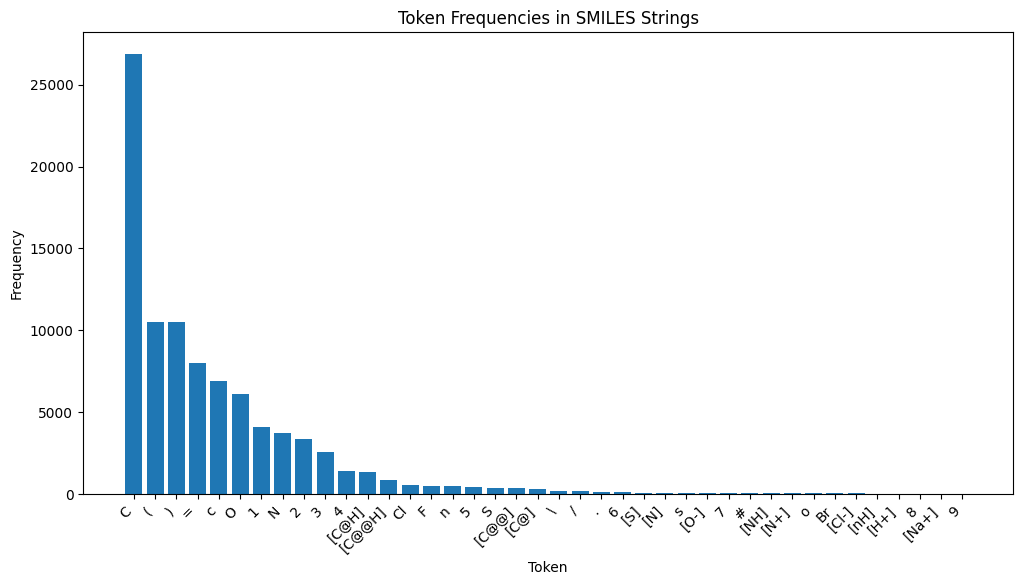

Vocab {'%14', 'Cl', '[S@]', '9', '(', '[CH2-]', '[C@]', 'S', 'F', '[N+]', 'B', '6', '[NH2]', '[H]', '[H+]', '[Ca++]', '[N@]', '#', '[NH2+]', '[S+]', 'O', '3', 's', '[nH]', '[Br-]', '[n+]', '%10', '[C@@]', '8', '[Na+]', '[nH+]', '[C-]', '[OH-]', '7', '[O-]', 'Br', '[N@@]', 'c', '[N]', '4', ')', '[Cl-]', '[NH3+]', '[O+]', 'n', '5', 'C', '%13', '[NH+]', 'o', '[S]', '[P]', '[CH-]', '[C@H]', '1', '[Na]', '%11', '2', '[o+]', 'I', '[NH]', '%12', '[Cl]', 'N', '=', '[C@@H]', '\\', '/', '[N-]', '.', '[NH-]'}
Vocab Size 71


In [15]:
from collections import Counter
import re

smiles_list = df['smiles']
# From DeepChem
SMILE_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""

all_tokens = ''.join(smiles_list)
tokens = re.findall(SMILE_REGEX_PATTERN, all_tokens)

unique_tokens = set(tokens)
token_counter = Counter(tokens)

# Plotting
top_n_tokens = 40
top_tokens = dict(token_counter.most_common(top_n_tokens))
plt.figure(figsize=(12, 6))
plt.bar(top_tokens.keys(), top_tokens.values())
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.title('Token Frequencies in SMILES Strings')
plt.show()

print("Vocab",unique_tokens)
print("Vocab Size",len(unique_tokens))

## Tokenization and One-Hot Encoding

This code segment tokenizes and one-hot encodes SMILES strings for molecular classification.

Each unique token in the dataset is assigned a unique index, with additional indices for 'PAD' (padding) and 'UNK' (unknown).

In [16]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Create a mapping from token to its index
token_to_index = {token: i+2 for i, token in enumerate(unique_tokens)}
token_to_index['PAD'] = 0
token_to_index['UNK'] = 1

# Tokenize
smiles_encoded = df['smiles'].apply(lambda x: [token_to_index[token] for token in re.findall(SMILE_REGEX_PATTERN, x)])

# Padding sequences on the left side
max_length = 128
# max_length = max(map(len, smiles_encoded))
smiles_padded = [[token_to_index['PAD']] * (max_length - len(seq)) + seq[-max_length:] if len(seq) < max_length else seq[-max_length:] for seq in smiles_encoded]
smiles_tensor = torch.tensor(smiles_padded)

# One hot encoding
encoder = OneHotEncoder(categories='auto', sparse_output=False)
smiles_onehot = encoder.fit_transform(smiles_tensor.view(-1, 1))
smiles_onehot = smiles_onehot.reshape(smiles_tensor.shape[0], max_length, -1)

print("One-hot encoded SMILES matrix shape:", smiles_onehot.shape)


One-hot encoded SMILES matrix shape: (2050, 128, 72)


## Data Splitting and DataLoader Creation

the creation of DataLoader objects for both MLP and Recurrent models:

In [17]:
from sklearn.model_selection import train_test_split

X_MLP = smiles_onehot.reshape(smiles_onehot.shape[0],-1)
Y = torch.Tensor(df['p_np'])

# Split the data into training and testing sets
X_train_MLP, X_test_MLP, Y_train_MLP, Y_test_MLP = train_test_split(X_MLP, Y, test_size=0.2, random_state=42)
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(smiles_onehot, Y, test_size=0.2, random_state=42)

train_dataset_MLP = TensorDataset(torch.Tensor(X_train_MLP), torch.Tensor(Y_train_MLP))
test_dataset_MLP = TensorDataset(torch.Tensor(X_test_MLP), torch.Tensor(Y_test_MLP))
train_dataset_LSTM = TensorDataset(torch.Tensor(X_train_LSTM), torch.Tensor(Y_train_LSTM))
test_dataset_LSTM = TensorDataset(torch.Tensor(X_test_LSTM), torch.Tensor(Y_test_LSTM))

batch_size = 256
train_loader_MLP = DataLoader(
    train_dataset_MLP, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False
)
test_loader_MLP = DataLoader(
    test_dataset_MLP, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=False
)
train_loader_LSTM = DataLoader(
    train_dataset_LSTM, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False
)
test_loader_LSTM = DataLoader(
    test_dataset_LSTM, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=False
)

### Helper functions

here we define the functions `train_model_kfold`, `plot_loss_acc`, `eval_model` functions, whose purpose is obvious by the name of the functions.

In [18]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from tqdm import tqdm
import copy

def train_model_kfold(model_gen, dataset, num_epochs, batch_size=256, k_folds=5, print_every=5):
    
    train_loss_list_best = []
    train_accuracy_list_best = []
    val_loss_list_best = []
    val_accuracy_list_best = []

    best_val_loss = float('inf')
    best_state_dict = None

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")
        
        model = model_gen()
        
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        train_loss_list = []
        train_accuracy_list = []
        val_loss_list = []
        val_accuracy_list = []
        
        for epoch in range(num_epochs):
            model.train()
            train_running_loss = 0.0
            train_running_accuracy = 0.0

            for inputs, labels in tqdm(train_loader, desc=f'epoch {epoch+1}/{num_epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                outputs = outputs.reshape_as(labels)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()

                # Measure accuracy
                predicted = (outputs > 0.5).float() 
                correct = (predicted == labels).sum().item()
                total = labels.size(0)
                train_running_accuracy += correct / total

            # Calculate average loss and accuracy for the training set
            train_epoch_loss = train_running_loss / len(train_loader)
            train_epoch_accuracy = train_running_accuracy / len(train_loader)

            # Validate on the validation set
            model.eval()
            val_running_loss = 0.0
            val_running_accuracy = 0.0
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_outputs = val_outputs.reshape_as(val_labels)
                    val_running_loss += criterion(val_outputs, val_labels).item()
                    val_predicted = (val_outputs > 0.5).float() 
                    val_correct = (val_predicted == val_labels).sum().item()
                    val_total = val_labels.size(0)
                    val_running_accuracy += val_correct / val_total
            
            val_epoch_loss = val_running_loss / len(val_loader)
            val_epoch_accuracy = val_running_accuracy / len(val_loader)
            
            if (epoch + 1) % print_every == 0:
                print(f'''
                Epoch {epoch+1}/{num_epochs}, training loss: {train_epoch_loss:.4f}, validation loss:{val_epoch_loss}
                training Accuracy: {100*train_epoch_accuracy:.2f}%, validation Accuracy: {100*val_epoch_accuracy:.2f}%
                ''')
                
            train_loss_list.append(train_epoch_loss)
            train_accuracy_list.append(train_epoch_accuracy)
            val_loss_list.append(val_epoch_loss)
            val_accuracy_list.append(val_epoch_accuracy)
        
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            train_loss_list_best = train_loss_list
            train_accuracy_list_best = train_accuracy_list
            val_loss_list_best = val_loss_list
            val_accuracy_list_best = val_accuracy_list
            best_state_dict = model.state_dict()
            
    return train_loss_list_best, train_accuracy_list_best, val_loss_list_best, val_accuracy_list_best, best_state_dict

In [19]:
def plot_loss_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list):
    plt.figure(figsize=(15, 8))

    # Plot Training Loss and Accuracy
    plt.subplot(2, 1, 1)
    plt.plot(train_loss_list, label='Training Loss', marker='o')
    plt.plot(val_loss_list, label='Validation Loss', marker='o', color='red')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_accuracy_list, label='Training Accuracy', marker='o', color='orange')
    plt.plot(val_accuracy_list, label='Validation Accuracy', marker='o', color='green')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [20]:
def eval_model(model, dataset, device):
    model.eval()
    running_accuracy = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataset):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = outputs.reshape_as(labels)
            predicted = (outputs > 0.5).float()
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            running_accuracy += correct
            total_samples += total
    test_accuracy = running_accuracy / total_samples
    return test_accuracy


## Define FC network

here we will define the FC network with Binary cross entropy loss.

In [21]:
input_size = X_train_MLP.shape[-1]
fc_model_gen = lambda: nn.Sequential(
    nn.Linear(input_size, 1),
    nn.Sigmoid()
).to(device)

fc_model = fc_model_gen()
fc_model

Sequential(
  (0): Linear(in_features=9216, out_features=1, bias=True)
  (1): Sigmoid()
)

### Training FC Network

Fold 1/5


epoch 20/20: 100%|██████████| 6/6 [00:00<00:00, 163.37it/s]



                Epoch 20/20, training loss: 0.1112, validation loss:0.2499832808971405
                training Accuracy: 96.74%, validation Accuracy: 88.52%
                
Fold 2/5


epoch 20/20: 100%|██████████| 6/6 [00:00<00:00, 154.63it/s]



                Epoch 20/20, training loss: 0.1272, validation loss:0.318851962685585
                training Accuracy: 94.66%, validation Accuracy: 85.33%
                
Fold 3/5


epoch 20/20: 100%|██████████| 6/6 [00:00<00:00, 153.83it/s]



                Epoch 20/20, training loss: 0.1199, validation loss:0.2844282239675522
                training Accuracy: 97.72%, validation Accuracy: 88.80%
                
Fold 4/5


epoch 20/20: 100%|██████████| 6/6 [00:00<00:00, 160.28it/s]



                Epoch 20/20, training loss: 0.1154, validation loss:0.23075056076049805
                training Accuracy: 96.81%, validation Accuracy: 90.76%
                
Fold 5/5


epoch 20/20: 100%|██████████| 6/6 [00:00<00:00, 128.08it/s]



                Epoch 20/20, training loss: 0.1311, validation loss:0.31470344960689545
                training Accuracy: 96.22%, validation Accuracy: 87.91%
                


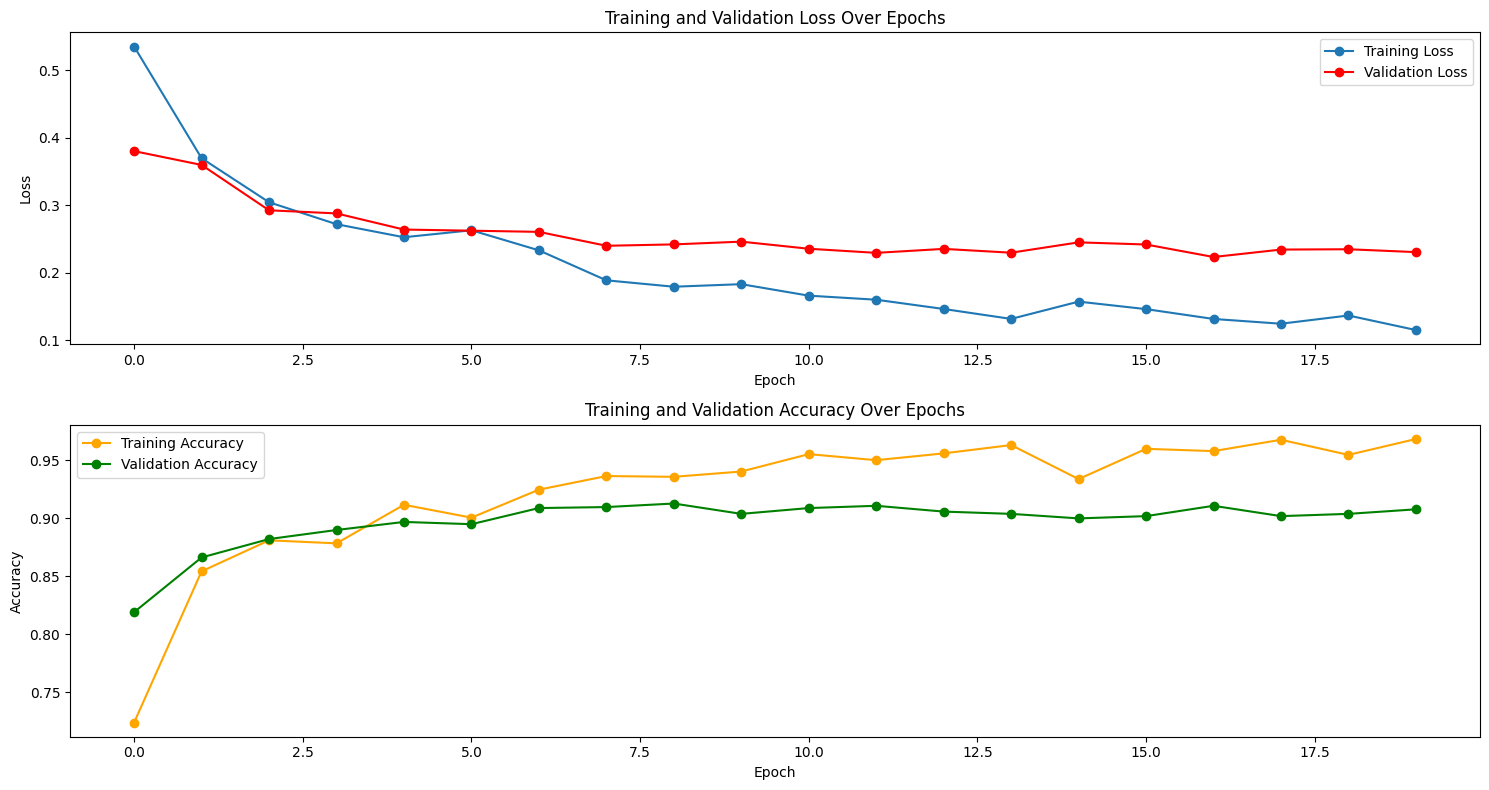

In [22]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, best_state_dict = train_model_kfold(
    fc_model_gen, train_loader_MLP.dataset, num_epochs=20, print_every=20, k_folds = 5,
)
fc_model.load_state_dict(best_state_dict)
plot_loss_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

we observe a steadily decreasing loss with increasing accuracy showcasing proper training of the model.

### Testing FC Network

here we evaluate the FC networks accuracy, using this as the baseline accuracy for our models.

In [23]:
test_accuracy_FC = eval_model(fc_model, test_loader_MLP, device)
print(f'Fully connected model accuracy over test dataset: {100*test_accuracy_FC:.2f}%')

100%|██████████| 2/2 [00:00<00:00, 14.97it/s]

Fully connected model accuracy over test dataset: 85.12%


## RNN for SMILES Classification

The following code defines a simple Long Short Time Memory Neural Network (LSTM) model for SMILES string classification.

the model has a single LSTM module, with a learnable initial state parameter, and optional input `bidirectional` to specify the bidirectional nature of the LSTM module. 

the model also has a single FC head to perform binary classification.

In [24]:
from torch.nn.parameter import Parameter

class LSTM_smiles(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(LSTM_smiles, self).__init__()
        self.input_size_var = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        # Make the initial states a learnable constant
        self.h0 = Parameter(
            torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 1, self.hidden_size)
        )
        self.c0 = Parameter(
            torch.zeros_like(self.h0)
        )
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(2 * hidden_size if self.bidirectional else hidden_size, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        h0 = self.h0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        c0 = self.c0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        
        # (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        if self.bidirectional:
            out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)
        else:
            out = out[:, -1, :].reshape(out.shape[0], -1)
        
        # Fully connected head
        out = self.fc(out)
        out = self.act(out)
        return out


### Define LSTM model

In [25]:
input_size = X_train_LSTM.shape[-1]
lstm_model_gen = lambda: LSTM_smiles(
    input_size,
    hidden_size = 64,
    num_layers = 4,
    bidirectional = False,
).to(device)

lstm_model = lstm_model_gen()
lstm_model

LSTM_smiles(
  (lstm): LSTM(72, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)

### Training the model

Fold 1/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 70.74it/s]



                Epoch 50/50, training loss: 0.2242, validation loss:0.22182578593492508
                training Accuracy: 90.49%, validation Accuracy: 90.86%
                
Fold 2/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 68.32it/s]



                Epoch 50/50, training loss: 0.3834, validation loss:0.38241374492645264
                training Accuracy: 83.40%, validation Accuracy: 78.95%
                
Fold 3/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 70.70it/s]



                Epoch 50/50, training loss: 0.5626, validation loss:0.5490843653678894
                training Accuracy: 75.00%, validation Accuracy: 76.19%
                
Fold 4/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 72.79it/s]



                Epoch 50/50, training loss: 0.5464, validation loss:0.4955170154571533
                training Accuracy: 76.30%, validation Accuracy: 81.12%
                
Fold 5/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 71.89it/s]



                Epoch 50/50, training loss: 0.1509, validation loss:0.3600909858942032
                training Accuracy: 93.29%, validation Accuracy: 89.02%
                


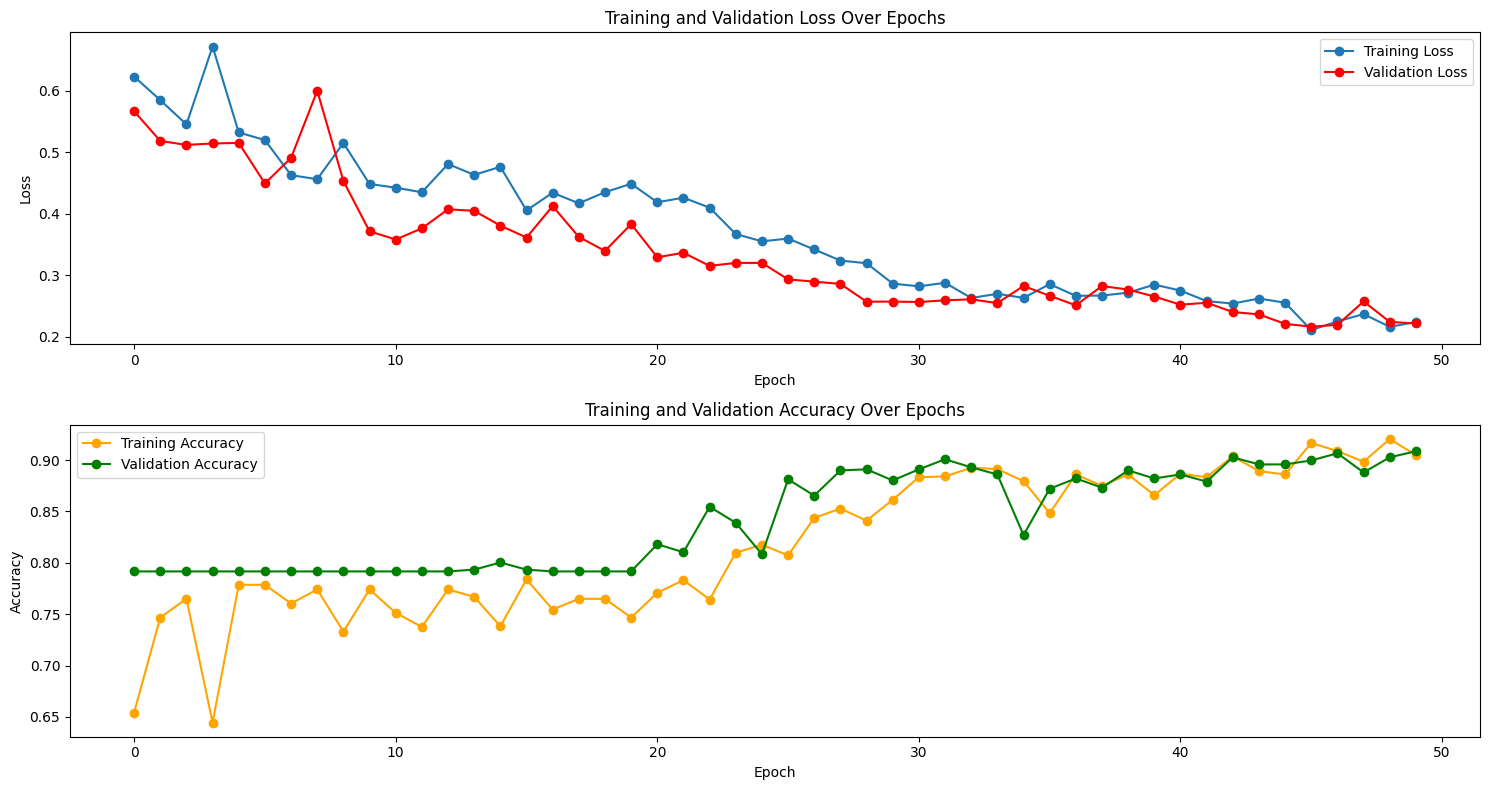

In [26]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, best_state_dict = train_model_kfold(
    lstm_model_gen, train_loader_LSTM.dataset, num_epochs=50, print_every=50, k_folds = 5,
)
lstm_model.load_state_dict(best_state_dict)
plot_loss_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

we observe a steadily decreasing loss with increasing accuracy showcasing proper training of the model.

### Testing LSTM model

In [27]:
test_accuracy_LSTM = eval_model(lstm_model, test_loader_LSTM, device)
print(f'LSTM model accuracy over test dataset: {100*test_accuracy_LSTM:.2f}%')

100%|██████████| 2/2 [00:00<00:00, 14.83it/s]

LSTM model accuracy over test dataset: 86.83%


## BiLSTM model

we repeat the same steps for a BiLSTM model.

In [28]:
input_size = X_train_LSTM.shape[-1]
bilstm_model_gen = lambda: LSTM_smiles(
    input_size,
    hidden_size = 64,
    num_layers = 4,
    bidirectional = True,
).to(device)

bilstm_model = bilstm_model_gen()
bilstm_model

LSTM_smiles(
  (lstm): LSTM(72, 64, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)

Fold 1/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 40.11it/s]



                Epoch 50/50, training loss: 0.1408, validation loss:0.2814655750989914
                training Accuracy: 94.47%, validation Accuracy: 88.32%
                
Fold 2/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 40.19it/s]



                Epoch 50/50, training loss: 0.1126, validation loss:0.28007762134075165
                training Accuracy: 95.83%, validation Accuracy: 90.86%
                
Fold 3/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 40.27it/s]



                Epoch 50/50, training loss: 0.3757, validation loss:0.33888867497444153
                training Accuracy: 78.26%, validation Accuracy: 80.23%
                
Fold 4/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 40.94it/s]



                Epoch 50/50, training loss: 0.5769, validation loss:0.5124863684177399
                training Accuracy: 74.48%, validation Accuracy: 81.12%
                
Fold 5/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 39.89it/s]



                Epoch 50/50, training loss: 0.4082, validation loss:0.41583043336868286
                training Accuracy: 76.95%, validation Accuracy: 77.30%
                


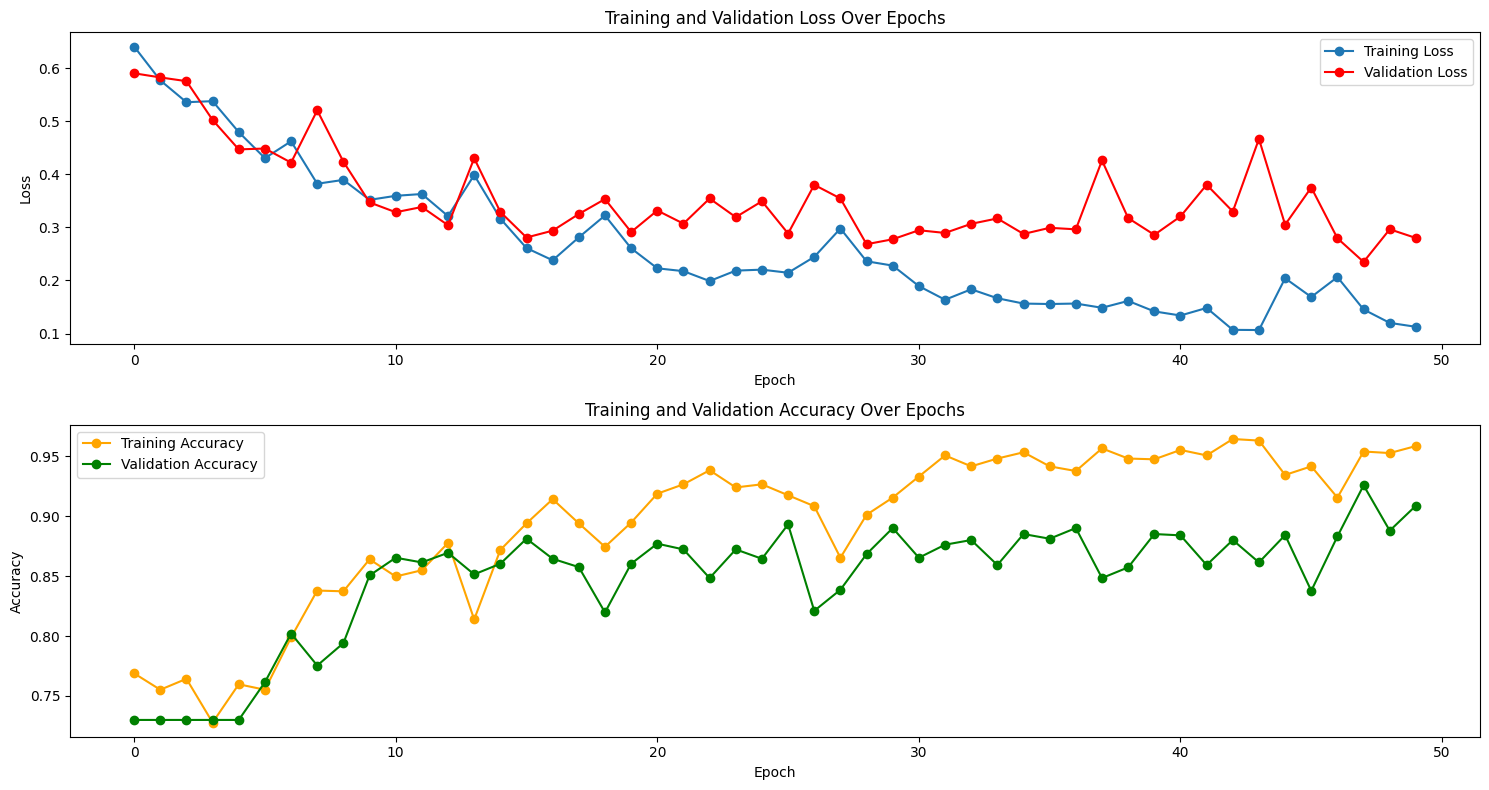

In [29]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, best_state_dict = train_model_kfold(
    bilstm_model_gen, train_loader_LSTM.dataset, num_epochs=50, print_every=50, k_folds = 5,
)
bilstm_model.load_state_dict(best_state_dict)
plot_loss_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

In [30]:
test_accuracy_BiLSTM = eval_model(bilstm_model, test_loader_LSTM, device)
print(f'BiLSTM model accuracy over test dataset: {100*test_accuracy_BiLSTM:.2f}%')

100%|██████████| 2/2 [00:00<00:00, 13.98it/s]

BiLSTM model accuracy over test dataset: 87.80%


## Vanilla RNN model

we will define a similar model to the previous `LSTM` implementation, however instead of the LSTM block we will use a vanilla RNN.

In [31]:
from torch.nn.parameter import Parameter


class RNN_smiles(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(RNN_smiles, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        # Make the initial states a learnable constant
        self.h0 = Parameter(
            torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 1, self.hidden_size)
        )
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(2 * hidden_size if self.bidirectional else hidden_size, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden state
        h0 = self.h0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        
        # (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x, h0)
        
        if self.bidirectional:
            # Concatenate the last hidden state from both directions
            out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)
        else:
            # Use the last hidden state from the single direction
            out = out[:, -1, :]
        
        # Fully connected head
        out = self.fc(out)
        out = self.act(out)
        return out

## Define RNN model

we repeat the same steps for the Vanilla RNN model.

In [32]:
input_size = X_train_LSTM.shape[-1]
rnn_model_gen = lambda: RNN_smiles(
    input_size,
    hidden_size = 64,
    num_layers = 4,
    bidirectional = False,
).to(device)

rnn_model = rnn_model_gen()

### Training the model

Fold 1/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 110.89it/s]



                Epoch 50/50, training loss: 0.5340, validation loss:0.5127785801887512
                training Accuracy: 77.86%, validation Accuracy: 79.17%
                
Fold 2/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 109.62it/s]



                Epoch 50/50, training loss: 0.5206, validation loss:0.5922755897045135
                training Accuracy: 78.71%, validation Accuracy: 73.00%
                
Fold 3/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 96.08it/s]



                Epoch 50/50, training loss: 0.5543, validation loss:0.547981321811676
                training Accuracy: 76.37%, validation Accuracy: 76.19%
                
Fold 4/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 107.29it/s]



                Epoch 50/50, training loss: 0.5510, validation loss:0.4992486387491226
                training Accuracy: 76.76%, validation Accuracy: 81.12%
                
Fold 5/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 99.68it/s]



                Epoch 50/50, training loss: 0.5626, validation loss:0.5363110601902008
                training Accuracy: 75.13%, validation Accuracy: 77.30%
                


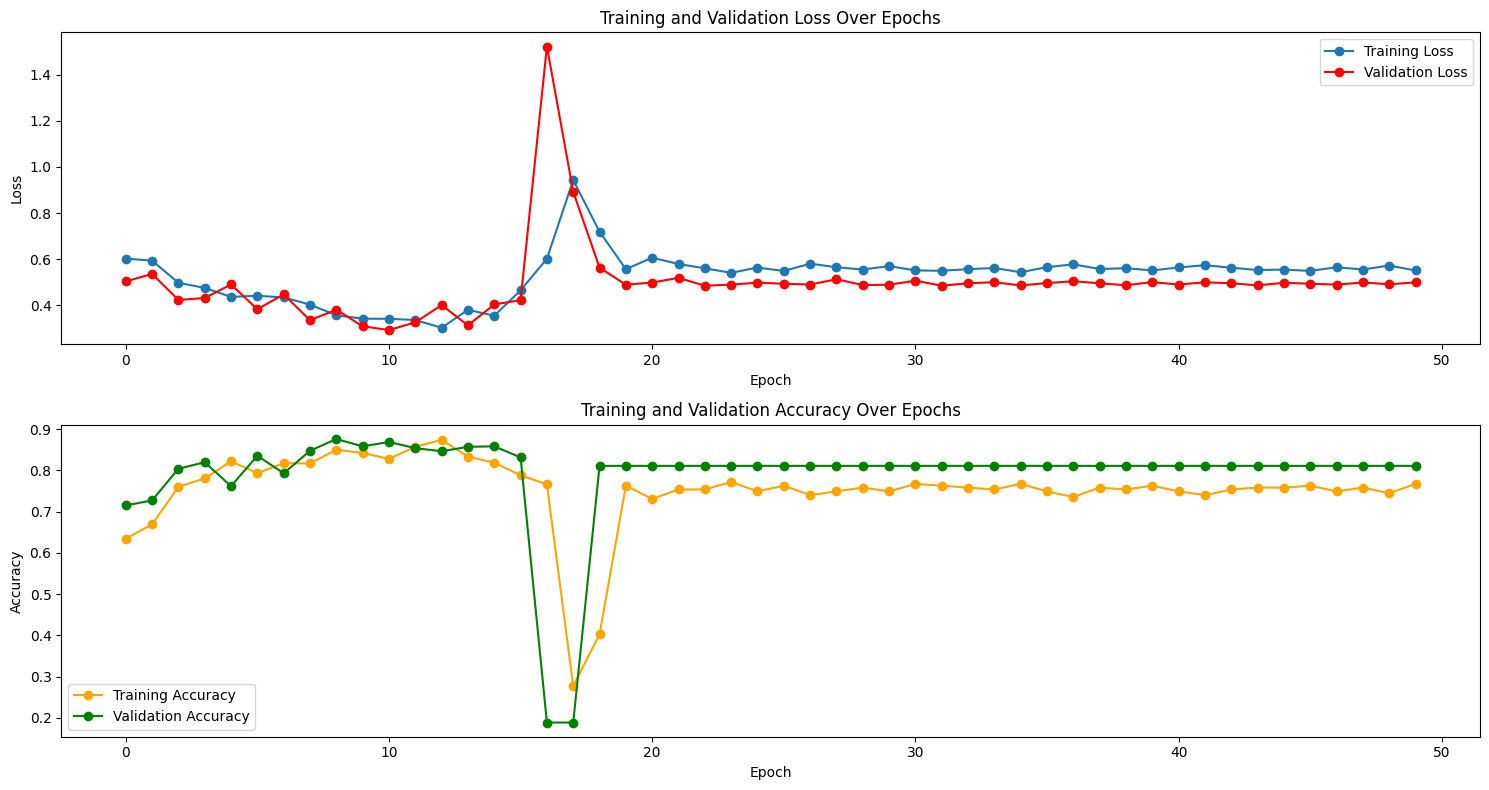

In [33]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, best_state_dict = train_model_kfold(
    rnn_model_gen, train_loader_LSTM.dataset, num_epochs=50, print_every=50, k_folds = 5,
)
rnn_model.load_state_dict(best_state_dict)
plot_loss_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

In [34]:
test_accuracy_RNN = eval_model(rnn_model, test_loader_LSTM, device)
print(f'RNN model accuracy over test dataset: {100*test_accuracy_RNN:.2f}%')

100%|██████████| 2/2 [00:00<00:00, 13.58it/s]

RNN model accuracy over test dataset: 76.83%


## Define BiRNN model

and the same steps for a bidirectional rnn model.

In [35]:
input_size = X_train_LSTM.shape[-1]
birnn_model_gen = lambda: RNN_smiles(
    input_size,
    hidden_size = 64,
    num_layers = 4,
    bidirectional = True,
).to(device)

birnn_model = birnn_model_gen()
birnn_model

RNN_smiles(
  (rnn): RNN(72, 64, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)

Fold 1/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 80.39it/s]



                Epoch 50/50, training loss: 0.4868, validation loss:0.44588299095630646
                training Accuracy: 76.50%, validation Accuracy: 80.25%
                
Fold 2/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 79.49it/s]



                Epoch 50/50, training loss: 0.4589, validation loss:0.49322402477264404
                training Accuracy: 78.71%, validation Accuracy: 73.00%
                
Fold 3/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 75.93it/s]



                Epoch 50/50, training loss: 0.4883, validation loss:0.502731591463089
                training Accuracy: 76.56%, validation Accuracy: 76.39%
                
Fold 4/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 78.29it/s]



                Epoch 50/50, training loss: 0.5680, validation loss:0.48746974766254425
                training Accuracy: 74.93%, validation Accuracy: 81.12%
                
Fold 5/5


epoch 50/50: 100%|██████████| 6/6 [00:00<00:00, 76.10it/s]



                Epoch 50/50, training loss: 0.3856, validation loss:0.43537627160549164
                training Accuracy: 79.69%, validation Accuracy: 79.14%
                


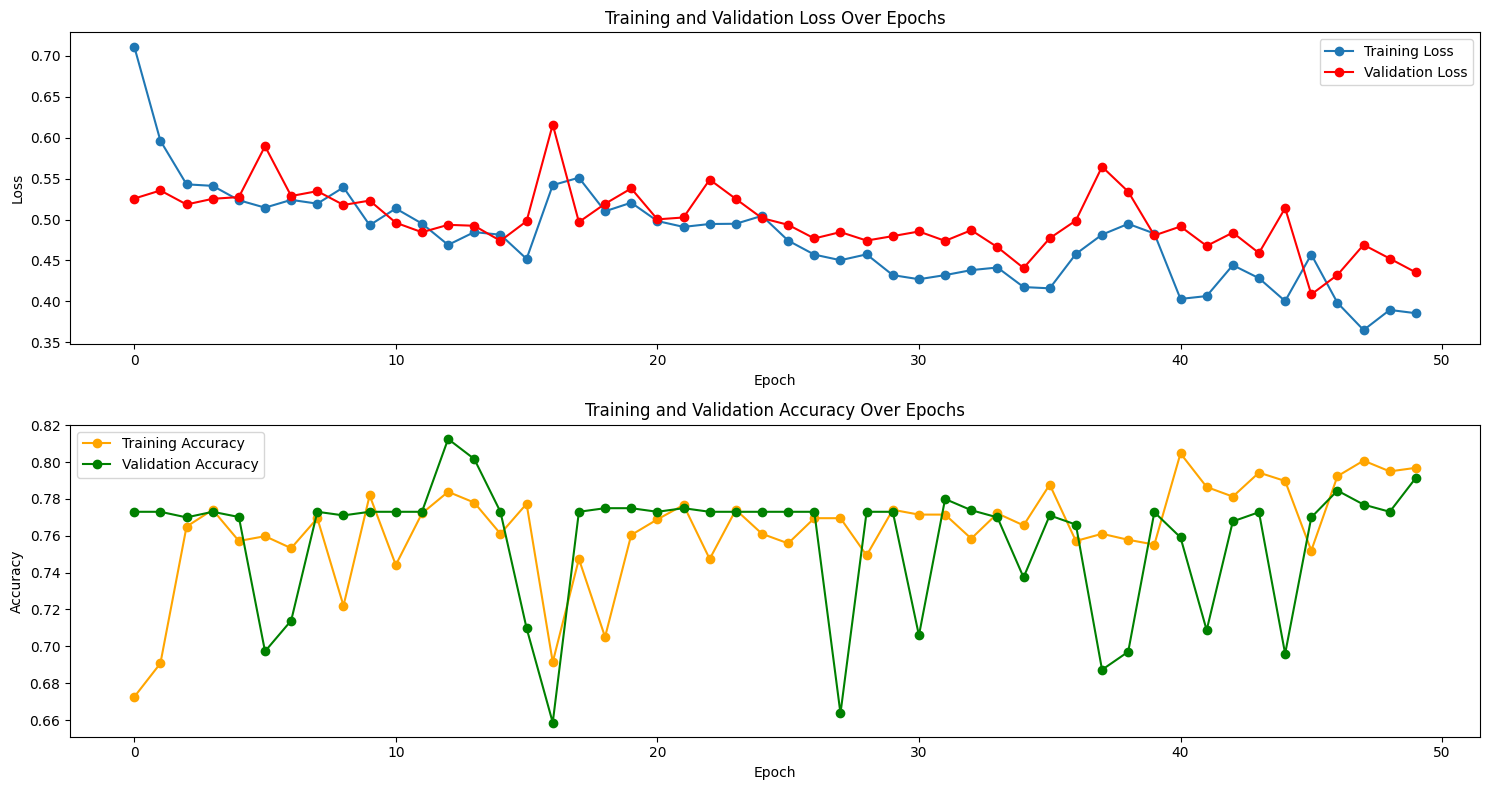

In [36]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, best_state_dict = train_model_kfold(
    birnn_model_gen, train_loader_LSTM.dataset, num_epochs=50, print_every=50, k_folds = 5,
)
birnn_model.load_state_dict(best_state_dict)
plot_loss_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

In [37]:
test_accuracy_BiRNN = eval_model(birnn_model, test_loader_LSTM, device)
print(f'BiRNN model accuracy over test dataset: {100*test_accuracy_BiRNN:.2f}%')

100%|██████████| 2/2 [00:00<00:00, 13.23it/s]

BiRNN model accuracy over test dataset: 75.61%


# Model Evaluation and Comparison

In this section, we evaluate and compare the accuracies of different models on distinct data bins. The models considered are:

- **fc_model(baseline):** Baseline fully connected model.
- **lstm_model:** Long Short-Term Memory (LSTM) model.
- **bilstm_model:** Bidirectional LSTM model.
- **rnn_model:** Vanilla Recurrent Neural Network (RNN) model.
- **birnn_model:** Bidirectional RNN model.

The evaluation is performed for each model on specific data length bins, and accuracies are recorded. The bar plot below visualizes the accuracies of each model for different bins.

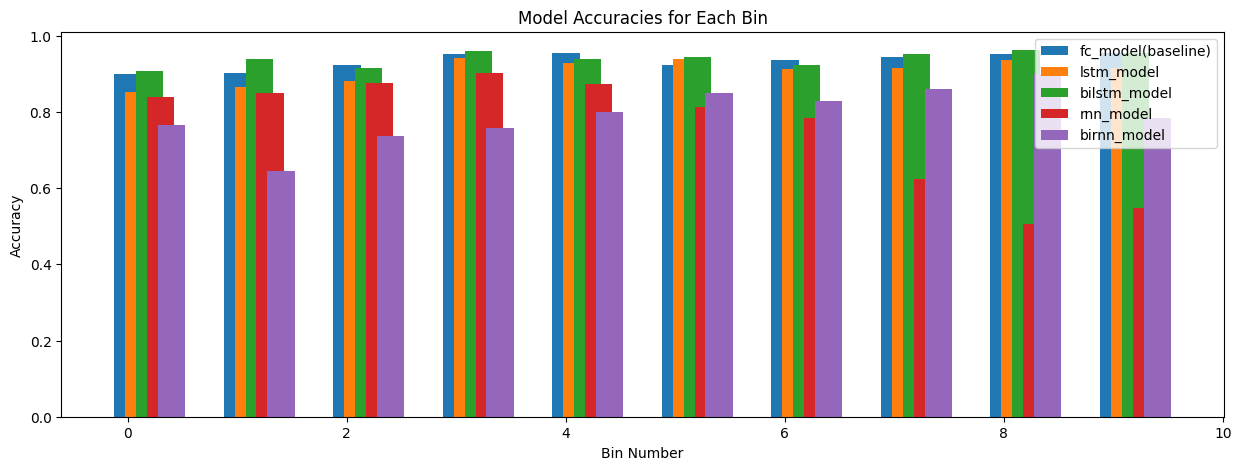

In [38]:
import matplotlib.pyplot as plt

accuracies = {model_name: [] for model_name in ['fc_model(baseline)', 'lstm_model', 'bilstm_model', 'rnn_model', 'birnn_model']}

for bin_num, bin_idx in bin_indices.items():
    # Evaluate fc_model(baseline)
    inputs, labels = X_MLP[bin_idx], Y[bin_idx]
    inputs, labels = torch.Tensor(inputs).to(device), torch.Tensor(labels).to(device)
    fc_model.eval()
    fc_predictions = fc_model(inputs)
    fc_predictions = fc_predictions.reshape_as(labels)
    predicted = (fc_predictions > 0.5).float() 
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    fc_accuracy = correct / total
    accuracies['fc_model(baseline)'].append(fc_accuracy)

    # Evaluate sequential models
    seq_models = [lstm_model, bilstm_model, rnn_model, birnn_model]
    for model, model_name in zip(seq_models, ['lstm_model', 'bilstm_model', 'rnn_model', 'birnn_model']):
        inputs, labels = smiles_onehot[bin_idx], Y[bin_idx]
        inputs, labels = torch.Tensor(inputs).to(device), torch.Tensor(labels).to(device)
        model.eval()
        seq_predictions = model(inputs)
        seq_predictions = seq_predictions.reshape_as(labels)
        predicted = (seq_predictions > 0.5).float() 
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        seq_accuracy = correct / total
        accuracies[model_name].append(seq_accuracy)

# Plotting
bin_numbers = list(bin_indices.keys())
bar_positions = np.arange(len(bin_indices))
plt.figure(figsize=(15, 5))
bar_width = 0.25
num_models = len(accuracies)
for i, model_name in enumerate(['fc_model(baseline)', 'lstm_model', 'bilstm_model', 'rnn_model', 'birnn_model']):
    plt.bar(bar_positions + 2 * i * bar_width / num_models, accuracies[model_name], width=bar_width, label=model_name)

plt.xlabel('Bin Number')
plt.ylabel('Accuracy')
plt.title('Model Accuracies for Each Bin')
plt.legend()
plt.show()

we observe diminishing accuracy for the vanilla RNN and LSTM models as the sequence length increases. This behavior indicates a challenge for vanilla RNNs in effectively capturing long-range dependencies within sequences.

this is mostly caused by the paddings, making the model forget old dependencies, however as we can see the bidirectional models outperform the others and don't have this weakness.

poor performance from rnn models stems from the problems associated with this model, as in gradient vanishing and such which are addressed in the lstm models.

overall the best model, as expected it the biLstm model, which has both great gradient flow and good memory preservation.